In [20]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR

# from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic


import src.lstm_helper as lh
import src.time_series_helpers as th

/Users/nicochen/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/nicochen/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/nicochen/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/nicochen/opt/anaconda3/lib/python3.7/site-packages/ten

In [2]:
# reference:
# https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
# https://www.statsmodels.org/dev/vector_ar.html#var
# https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

In [3]:
ls data/

LSTM_10_output_forecast.csv  processed_train.csv
LSTM_500_by_item.csv         sample_submission.csv
LSTM_500_forecast.csv        sample_valid.csv
VAR_by_item.csv              store_item.csv
VAR_forecast.csv             test.csv
lstm_10_by_item.csv          train.csv
lstm_data.csv


In [7]:
store_item = pd.read_csv('data/store_item.csv')

In [8]:
store_item.head()

,date,s1_i1,s1_i2,s1_i3,s1_i4,s1_i5,s1_i6,s1_i7,s1_i8,s1_i9,...,s10_i41,s10_i42,s10_i43,s10_i44,s10_i45,s10_i46,s10_i47,s10_i48,s10_i49,s10_i50
0,2013-01-01,13,33,15,10,11,31,25,33,18,...,12,20,24,17,45,37,11,25,17,33
1,2013-01-02,11,43,30,11,6,36,23,37,23,...,10,22,29,10,45,33,13,24,13,37
2,2013-01-03,14,23,14,8,8,18,34,38,25,...,17,27,43,20,56,28,16,29,19,46
3,2013-01-04,13,18,10,19,9,19,36,54,22,...,13,24,27,12,50,44,11,39,23,51
4,2013-01-05,10,34,23,12,8,31,38,51,29,...,14,25,31,25,62,45,16,34,22,41


In [9]:
#set datatime to index
store_item['date'] = pd.to_datetime(store_item['date'])
store_item = store_item.set_index('date')

In [10]:
store_item.head()

,s1_i1,s1_i2,s1_i3,s1_i4,s1_i5,s1_i6,s1_i7,s1_i8,s1_i9,s1_i10,...,s10_i41,s10_i42,s10_i43,s10_i44,s10_i45,s10_i46,s10_i47,s10_i48,s10_i49,s10_i50
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,13,33,15,10,11,31,25,33,18,37,...,12,20,24,17,45,37,11,25,17,33
2013-01-02,11,43,30,11,6,36,23,37,23,34,...,10,22,29,10,45,33,13,24,13,37
2013-01-03,14,23,14,8,8,18,34,38,25,32,...,17,27,43,20,56,28,16,29,19,46
2013-01-04,13,18,10,19,9,19,36,54,22,45,...,13,24,27,12,50,44,11,39,23,51
2013-01-05,10,34,23,12,8,31,38,51,29,35,...,14,25,31,25,62,45,16,34,22,41


In [11]:
#split into train and valid sets
train_original = store_item.loc['2013-01-01':'2017-09-30']
valid_original  = store_item.loc['2017-10-01':'2017-12-31']

In [12]:
train_original.shape

(1734, 500)

In [13]:
df = store_item.copy()

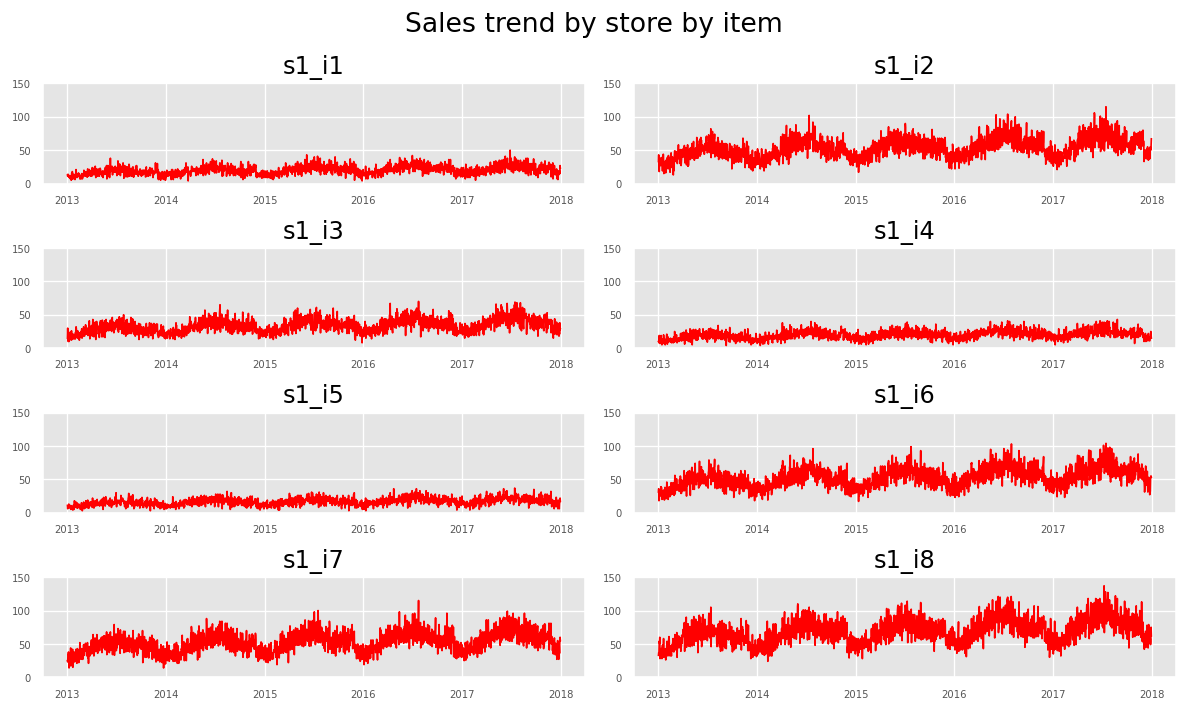

In [14]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))

for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_ylim(0,150)
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    
fig.suptitle("Sales trend by store by item", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88);
plt.savefig('images/Sales_trend_by_store_by_item.png')

#### Check for Stationarity and Make the Time Series Stationary

##### ADF Test

In [13]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [14]:
sampling = random.choices(np.arange(train_original.shape[1]), k=10)
sampling 

[208, 204, 367, 212, 7, 483, 270, 143, 249, 3]

In [15]:
df_train=train_original.iloc[:,sampling]
df_train.head()

,s5_i9,s5_i5,s8_i18,s5_i13,s1_i8,s10_i34,s6_i21,s3_i44,s5_i50,s1_i4
date,,,,,,,,,,
2013-01-01,21,9,52,33,33,15,15,19,19,10
2013-01-02,20,5,47,28,37,13,16,22,25,11
2013-01-03,15,3,51,36,38,19,23,18,28,8
2013-01-04,20,12,61,45,54,16,12,20,27,19
2013-01-05,23,8,74,40,51,15,22,24,31,12


In [16]:
# ADF Test on 10 columns
df_train=train_original.iloc[:]
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "s1_i1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9366
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0413. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s1_i2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8589
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0503. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s1_i3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationar

    Augmented Dickey-Fuller Test on "s1_i21" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6755
 No. Lags Chosen       = 22
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0784. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s1_i22" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.5983
 No. Lags Chosen       = 21
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0933. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s1_i23" 
    -----------------------------------------------
 Null Hypothesis: Data has

    Augmented Dickey-Fuller Test on "s1_i41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1699
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0218. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s1_i42" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8541
 No. Lags Chosen       = 25
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.051. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s1_i43" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Station

    Augmented Dickey-Fuller Test on "s2_i11" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.4646
 No. Lags Chosen       = 22
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.1243. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s2_i12" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6636
 No. Lags Chosen       = 22
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0805. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s2_i13" 
    -----------------------------------------------
 Null Hypothesis: Data has

    Augmented Dickey-Fuller Test on "s2_i33" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7211
 No. Lags Chosen       = 22
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0705. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s2_i34" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8554
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0508. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s2_i35" 
    -----------------------------------------------
 Null Hypothesis: Data has

    Augmented Dickey-Fuller Test on "s3_i5" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1422
 No. Lags Chosen       = 22
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0236. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s3_i6" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6939
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0751. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s3_i7" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationar

    Augmented Dickey-Fuller Test on "s3_i27" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9204
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.043. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s3_i28" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6229
 No. Lags Chosen       = 22
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0884. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s3_i29" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Station

    Augmented Dickey-Fuller Test on "s3_i50" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9168
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0434. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s4_i1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7211
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0704. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s4_i2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationa

    Augmented Dickey-Fuller Test on "s4_i22" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.743
 No. Lags Chosen       = 25
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0669. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s4_i23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7649
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0635. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s4_i24" 
    -----------------------------------------------
 Null Hypothesis: Data has 

    Augmented Dickey-Fuller Test on "s4_i42" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7024
 No. Lags Chosen       = 21
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0736. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s4_i43" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6501
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0831. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s4_i44" 
    -----------------------------------------------
 Null Hypothesis: Data has

    Augmented Dickey-Fuller Test on "s5_i12" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7762
 No. Lags Chosen       = 22
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0618. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s5_i13" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7241
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.07. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s5_i14" 
    -----------------------------------------------
 Null Hypothesis: Data has u

    Augmented Dickey-Fuller Test on "s5_i35" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8677
 No. Lags Chosen       = 25
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0492. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s5_i36" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6232
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0883. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s5_i37" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Statio

    Augmented Dickey-Fuller Test on "s6_i5" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.2635
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0166. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s6_i6" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8147
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0562. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s6_i7" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationar

    Augmented Dickey-Fuller Test on "s6_i25" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9938
 No. Lags Chosen       = 25
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0355. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s6_i26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.4174
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.1369. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s6_i27" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Statio

    Augmented Dickey-Fuller Test on "s6_i45" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7127
 No. Lags Chosen       = 25
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0719. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s6_i46" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7661
 No. Lags Chosen       = 21
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0633. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s6_i47" 
    -----------------------------------------------
 Null Hypothesis: Data has

    Augmented Dickey-Fuller Test on "s7_i16" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1956
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0202. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s7_i17" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9151
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0436. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s7_i18" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Le

    Augmented Dickey-Fuller Test on "s7_i39" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9326
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0417. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s7_i40" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8001
 No. Lags Chosen       = 22
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0583. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s7_i41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Statio

    Augmented Dickey-Fuller Test on "s8_i11" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8715
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0488. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s8_i12" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7351
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0682. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s8_i13" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Statio

    Augmented Dickey-Fuller Test on "s8_i32" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.011
 No. Lags Chosen       = 25
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0339. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s8_i33" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.0241
 No. Lags Chosen       = 25
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0327. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s8_i34" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Lev

    Augmented Dickey-Fuller Test on "s9_i2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8828
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0474. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s9_i3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6883
 No. Lags Chosen       = 21
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0761. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s9_i4" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationar

    Augmented Dickey-Fuller Test on "s9_i22" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7266
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0696. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s9_i23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.981
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0367. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s9_i24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Station

    Augmented Dickey-Fuller Test on "s9_i43" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8825
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0474. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s9_i44" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8799
 No. Lags Chosen       = 22
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0477. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s9_i45" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Le

    Augmented Dickey-Fuller Test on "s10_i14" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7093
 No. Lags Chosen       = 25
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0724. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s10_i15" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9044
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0448. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s10_i16" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Sta

    Augmented Dickey-Fuller Test on "s10_i35" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7177
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.071. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "s10_i36" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8913
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0464. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s10_i37" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stat

In [17]:
# 1st difference
differenced = train_original.diff().dropna()

In [18]:
differenced

,s1_i1,s1_i2,s1_i3,s1_i4,s1_i5,s1_i6,s1_i7,s1_i8,s1_i9,s1_i10,...,s10_i41,s10_i42,s10_i43,s10_i44,s10_i45,s10_i46,s10_i47,s10_i48,s10_i49,s10_i50
date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,-2.0,10.0,15.0,1.0,-5.0,5.0,-2.0,4.0,5.0,-3.0,...,-2.0,2.0,5.0,-7.0,0.0,-4.0,2.0,-1.0,-4.0,4.0
2013-01-03,3.0,-20.0,-16.0,-3.0,2.0,-18.0,11.0,1.0,2.0,-2.0,...,7.0,5.0,14.0,10.0,11.0,-5.0,3.0,5.0,6.0,9.0
2013-01-04,-1.0,-5.0,-4.0,11.0,1.0,1.0,2.0,16.0,-3.0,13.0,...,-4.0,-3.0,-16.0,-8.0,-6.0,16.0,-5.0,10.0,4.0,5.0
2013-01-05,-3.0,16.0,13.0,-7.0,-1.0,12.0,2.0,-3.0,7.0,-10.0,...,1.0,1.0,4.0,13.0,12.0,1.0,5.0,-5.0,-1.0,-10.0
2013-01-06,2.0,4.0,0.0,4.0,5.0,0.0,-6.0,9.0,6.0,19.0,...,-3.0,7.0,5.0,-6.0,2.0,5.0,1.0,13.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-26,4.0,12.0,12.0,0.0,1.0,4.0,-4.0,16.0,-2.0,22.0,...,-2.0,17.0,19.0,1.0,23.0,2.0,-2.0,16.0,-1.0,16.0
2017-09-27,9.0,-4.0,3.0,8.0,4.0,1.0,-1.0,-1.0,10.0,-12.0,...,1.0,-10.0,10.0,2.0,-6.0,11.0,7.0,-15.0,1.0,1.0
2017-09-28,-4.0,-2.0,-4.0,-10.0,2.0,-5.0,26.0,-22.0,-1.0,-2.0,...,13.0,13.0,2.0,1.0,4.0,-8.0,-7.0,9.0,0.0,2.0


#### Re-run ADF test on each differenced series.

In [19]:
df_differenced=differenced.iloc[:,sampling]

In [20]:
# ADF Test on each column of 1st Differences Dataframe

for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "s5_i9" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.0811
 No. Lags Chosen       = 19
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s5_i5" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.2353
 No. Lags Chosen       = 19
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "s8_i18" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level   

### Multivariate Forecast Model
#### Vector Autoregression (VAR)

In [ ]:
model = VAR(differenced)
model_fitted = model.fit(365)

# Input data for forecasting
forecast_input  = differenced.values[-365:]
forecast_output = model_fitted.forecast(y=forecast_input, steps=92)

In [26]:
model = VAR(differenced)


/Users/nicochen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [27]:
#choice lag = 365

In [28]:
model_fitted = model.fit(365)

In [29]:
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

365


In [30]:
# Input data for forecasting
forecast_input = differenced.values[-lag_order:]
forecast_input

array([[  2.,   2.,  -5., ...,  -1.,  -1.,  18.],
       [  1.,  -5.,  10., ...,   7.,  -3.,   4.],
       [ -6., -25., -18., ..., -29.,  -1., -22.],
       ...,
       [ -4.,  -2.,  -4., ...,   9.,   0.,   2.],
       [  5.,  11.,  -2., ...,   5.,  -4.,   8.],
       [  2.,  13.,  13., ...,  -1.,  -2.,  13.]])

In [31]:
forecast_input.shape

(365, 500)

In [32]:
valid_original.shape

(92, 500)

In [33]:
fc = model_fitted.forecast(y=forecast_input, steps=92)
fc.shape

(92, 500)

In [34]:
df_forecast = pd.DataFrame(fc, index=valid_original.index, columns=df.columns + '_1d')
df_forecast

,s1_i1_1d,s1_i2_1d,s1_i3_1d,s1_i4_1d,s1_i5_1d,s1_i6_1d,s1_i7_1d,s1_i8_1d,s1_i9_1d,s1_i10_1d,...,s10_i41_1d,s10_i42_1d,s10_i43_1d,s10_i44_1d,s10_i45_1d,s10_i46_1d,s10_i47_1d,s10_i48_1d,s10_i49_1d,s10_i50_1d
date,,,,,,,,,,,,,,,,,,,,,
2017-10-01,-1.701083,-6.143321,-0.643015,4.003380,2.890530,5.661241,-9.902416,5.244278,-2.594031,12.896117,...,0.605511,16.638627,3.811497,2.687025,11.634494,-5.679120,-1.030150,7.940018,13.015547,-1.535390
2017-10-02,-10.817533,-27.001452,-17.185234,-8.930922,-8.466089,-26.627363,-24.186088,-30.491102,-20.717280,-32.232516,...,-12.398276,-19.099715,-26.396783,-14.879350,-40.857622,-29.624555,-11.061535,-29.144646,-15.831981,-35.602006
2017-10-03,3.973955,8.396112,4.693019,2.276673,2.067192,9.695309,7.926552,9.229565,5.528175,11.993992,...,4.290650,4.204422,7.939190,3.809124,12.513427,10.337646,3.962498,6.724723,4.945528,10.077645
2017-10-04,1.230544,1.792950,0.528434,0.414693,1.850761,2.193768,-1.494784,-2.993325,2.893399,0.505613,...,0.708669,0.082690,0.602198,-1.399991,-0.771360,0.897957,-0.683321,2.894604,2.370574,1.025369
2017-10-05,-0.605748,1.385322,1.153636,0.982830,1.313603,1.329974,4.652122,4.141914,3.911523,4.453417,...,2.400597,2.360603,0.389577,0.114643,6.802754,1.774276,2.326173,3.699904,0.763474,4.617184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,1.049874,0.105122,0.709703,-0.055608,0.093627,-0.725573,0.368895,1.300924,0.289449,-0.675187,...,-0.080669,-0.616664,2.792552,-0.500119,4.722305,-2.748988,-0.631635,-0.339085,2.033832,0.705303
2017-12-28,0.294652,2.058298,0.608175,1.157019,0.735647,1.310495,1.112054,0.897453,1.877736,4.839246,...,0.559869,1.026562,0.280967,1.042074,0.568266,4.528396,2.390312,1.895721,-1.265379,5.055328
2017-12-29,2.217322,1.962241,1.910305,0.269057,-0.167026,2.960274,2.372649,1.574031,0.971925,1.822637,...,-0.455335,2.095527,2.000819,1.757482,3.633185,4.214011,0.755817,1.291484,2.142548,2.598197


#### Invert the transformation to get the real forecast

In [35]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
#         # Roll back 2nd Diff
#         if second_diff:
#             df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    
    df_fc = df_fc.iloc[:,df_train.shape[1]:]
    return df_fc

In [36]:
df_results = invert_transformation(train_original, df_forecast, second_diff=False)        


In [37]:
df_results.shape

(92, 500)

In [38]:
df_results

,s1_i1_forecast,s1_i2_forecast,s1_i3_forecast,s1_i4_forecast,s1_i5_forecast,s1_i6_forecast,s1_i7_forecast,s1_i8_forecast,s1_i9_forecast,s1_i10_forecast,...,s10_i41_forecast,s10_i42_forecast,s10_i43_forecast,s10_i44_forecast,s10_i45_forecast,s10_i46_forecast,s10_i47_forecast,s10_i48_forecast,s10_i49_forecast,s10_i50_forecast
date,,,,,,,,,,,,,,,,,,,,,
2017-10-01,28.298917,72.856679,47.356985,26.003380,21.890530,69.661241,70.097584,95.244278,61.405969,86.896117,...,33.605511,56.638627,79.811497,44.687025,119.634494,87.320880,32.969850,77.940018,44.015547,101.464610
2017-10-02,17.481383,45.855226,30.171751,17.072458,13.424441,43.033878,45.911496,64.753175,40.688689,54.663601,...,21.207235,37.538912,53.414714,29.807675,78.776872,57.696325,21.908315,48.795373,28.183566,65.862604
2017-10-03,21.455338,54.251338,34.864771,19.349130,15.491632,52.729187,53.838048,73.982740,46.216864,66.657594,...,25.497885,41.743334,61.353904,33.616799,91.290299,68.033972,25.870813,55.520095,33.129094,75.940249
2017-10-04,22.685883,56.044288,35.393204,19.763823,17.342394,54.922954,52.343265,70.989415,49.110263,67.163207,...,26.206554,41.826024,61.956102,32.216808,90.518939,68.931929,25.187492,58.414700,35.499668,76.965618
2017-10-05,22.080135,57.429610,36.546841,20.746653,18.655997,56.252928,56.995386,75.131329,53.021786,71.616624,...,28.607151,44.186628,62.345679,32.331451,97.321693,70.706204,27.513665,62.114604,36.263142,81.582802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,15.517599,43.387061,26.111563,15.260324,13.870246,44.218889,42.282628,57.373110,36.543536,51.729792,...,20.550360,32.645848,48.916504,25.874763,74.720639,51.683870,19.483391,47.281117,29.627659,57.181583
2017-12-28,15.812252,45.445359,26.719738,16.417343,14.605893,45.529384,43.394682,58.270563,38.421272,56.569038,...,21.110229,33.672411,49.197471,26.916837,75.288905,56.212265,21.873703,49.176839,28.362280,62.236911
2017-12-29,18.029574,47.407600,28.630043,16.686400,14.438867,48.489659,45.767331,59.844593,39.393197,58.391675,...,20.654894,35.767938,51.198290,28.674319,78.922090,60.426277,22.629520,50.468322,30.504829,64.835108


In [39]:
df_results.columns[0],df_results.columns[499]

('s1_i1_forecast', 's10_i50_forecast')

In [16]:
df_results = pd.read_csv('data/VAR_by_item.csv')
df_results['date'] = pd.to_datetime(df_results['date'])
df_results = df_results.set_index('date')
df_results.head()

,s1_i1_forecast,s1_i2_forecast,s1_i3_forecast,s1_i4_forecast,s1_i5_forecast,s1_i6_forecast,s1_i7_forecast,s1_i8_forecast,s1_i9_forecast,s1_i10_forecast,...,s10_i41_forecast,s10_i42_forecast,s10_i43_forecast,s10_i44_forecast,s10_i45_forecast,s10_i46_forecast,s10_i47_forecast,s10_i48_forecast,s10_i49_forecast,s10_i50_forecast
date,,,,,,,,,,,,,,,,,,,,,
2017-10-01,28.298917,72.856679,47.356985,26.003380,21.890530,69.661241,70.097584,95.244278,61.405969,86.896117,...,33.605511,56.638627,79.811497,44.687025,119.634494,87.320880,32.969850,77.940018,44.015547,101.464610
2017-10-02,17.481383,45.855226,30.171751,17.072458,13.424441,43.033878,45.911496,64.753175,40.688689,54.663601,...,21.207235,37.538912,53.414714,29.807675,78.776872,57.696325,21.908315,48.795373,28.183566,65.862604
2017-10-03,21.455338,54.251338,34.864771,19.349130,15.491632,52.729187,53.838048,73.982740,46.216864,66.657594,...,25.497885,41.743334,61.353904,33.616799,91.290299,68.033972,25.870813,55.520095,33.129094,75.940249
2017-10-04,22.685883,56.044288,35.393204,19.763823,17.342394,54.922954,52.343265,70.989415,49.110263,67.163207,...,26.206554,41.826024,61.956102,32.216808,90.518939,68.931929,25.187492,58.414700,35.499668,76.965618
2017-10-05,22.080135,57.429610,36.546841,20.746653,18.655997,56.252928,56.995386,75.131329,53.021786,71.616624,...,28.607151,44.186628,62.345679,32.331451,97.321693,70.706204,27.513665,62.114604,36.263142,81.582802


In [17]:
random.randint(1,500)

194

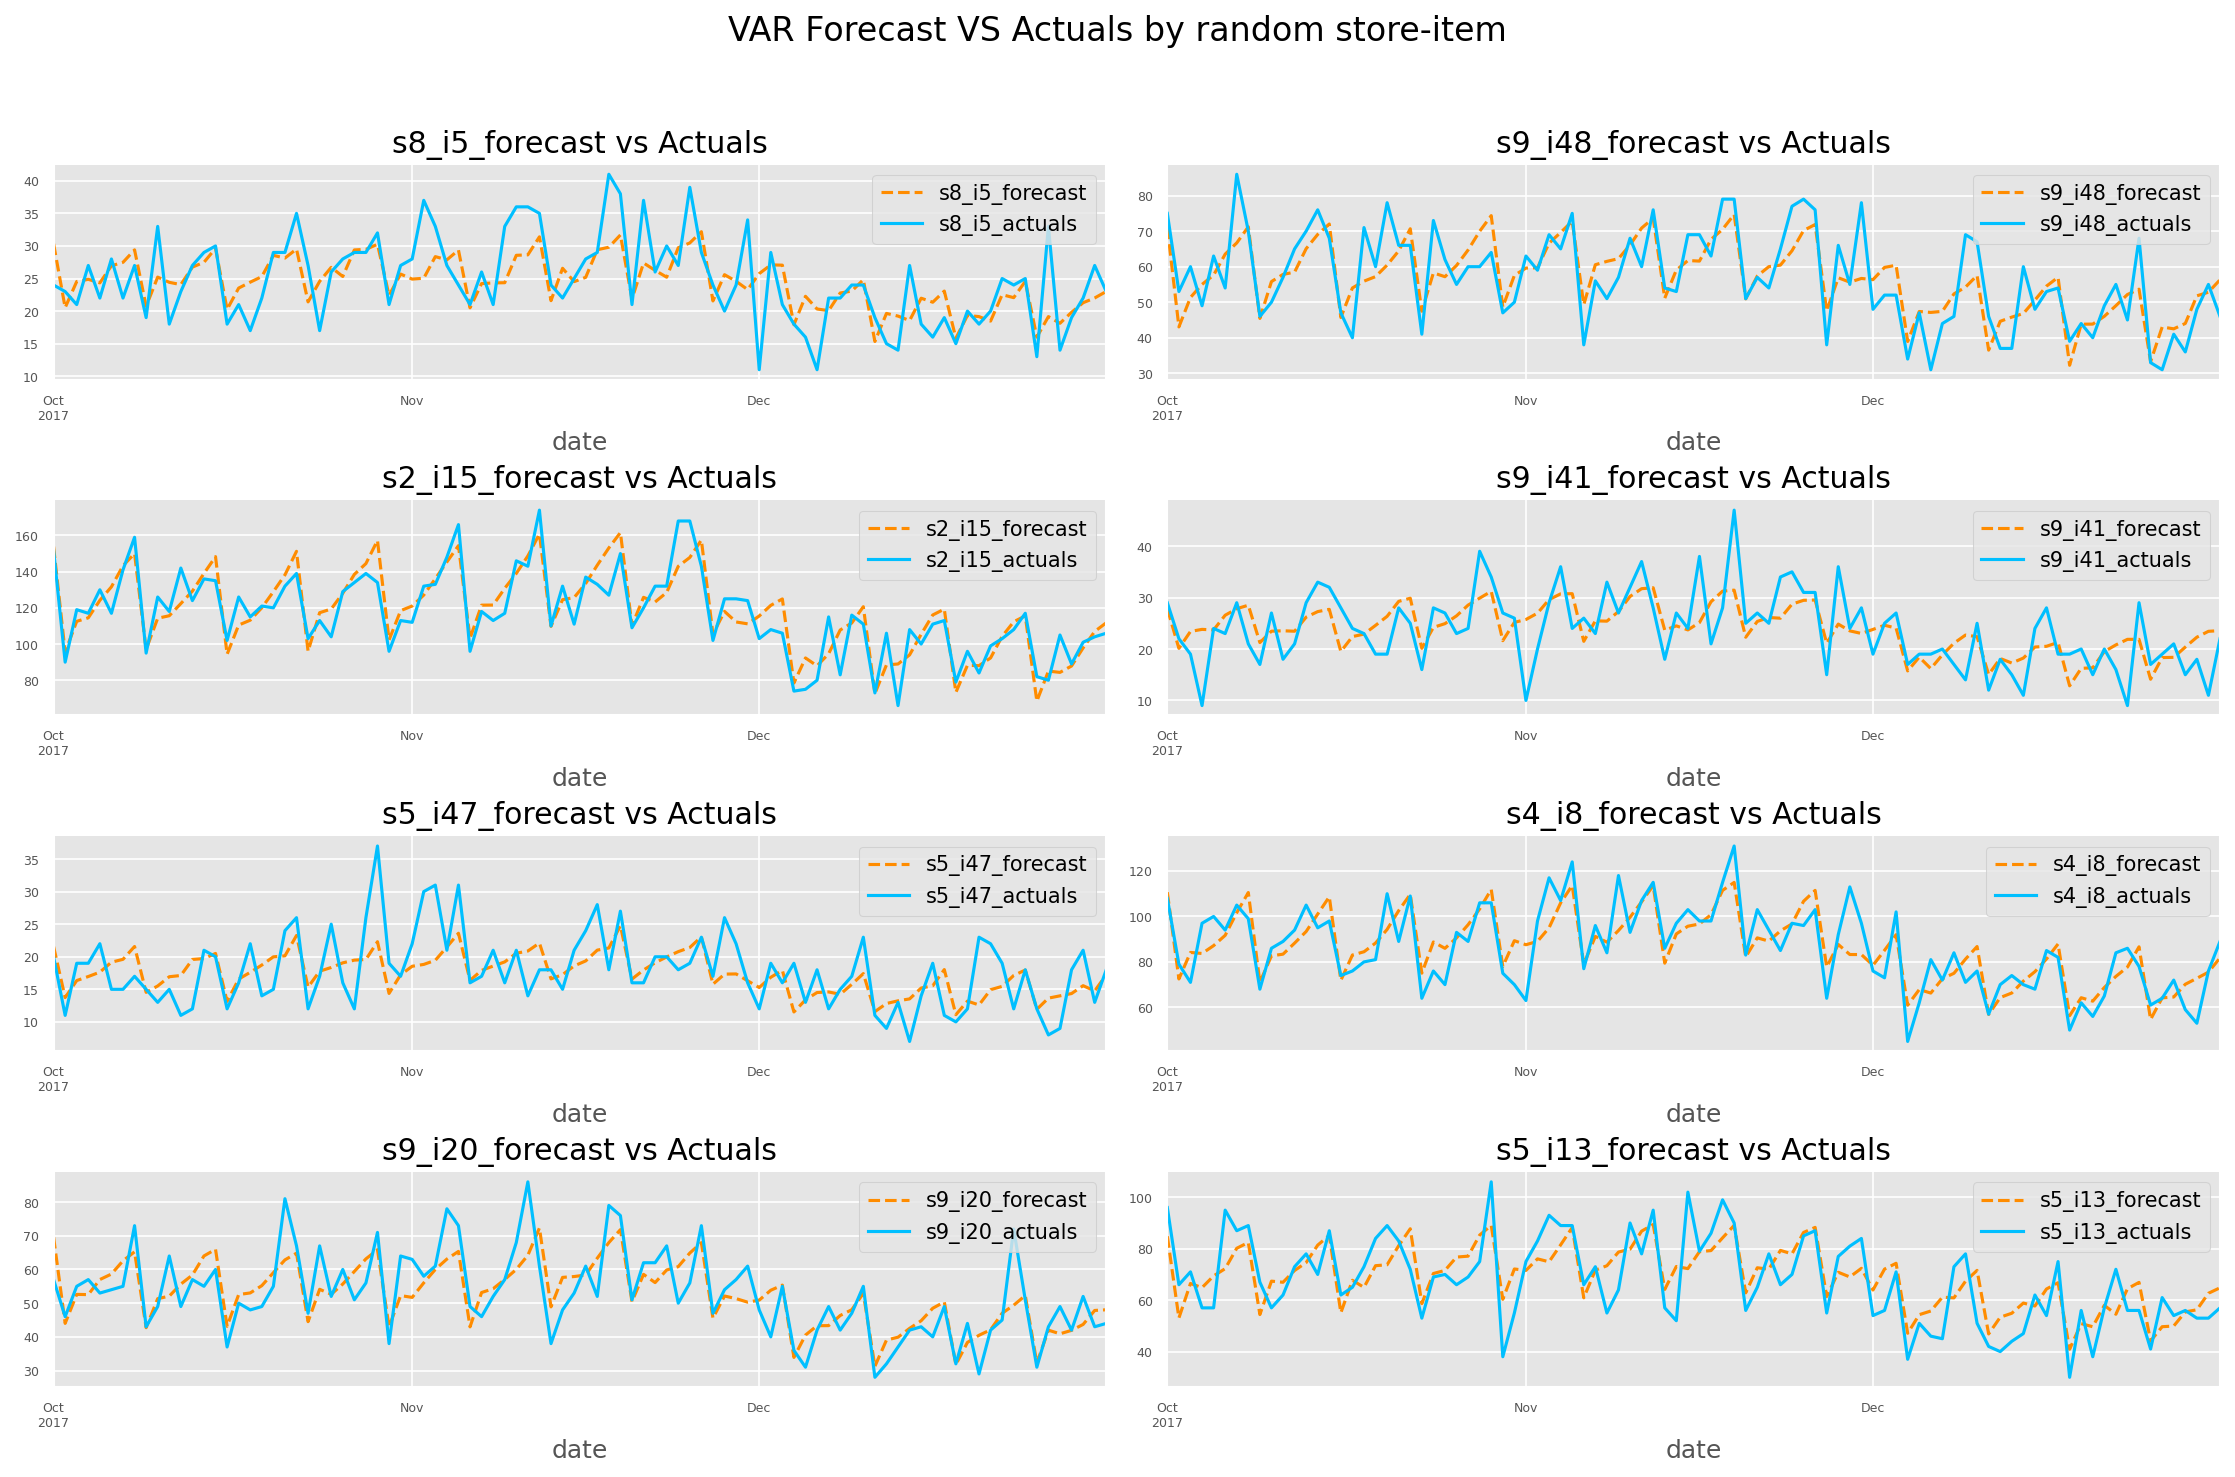

In [66]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=150, figsize=(15,10))
for i, ax in enumerate( axes.flatten()):
    col = random.randint(1,valid_original.shape[1])
    df_results[df_results.columns[col]].plot(legend=True, ax=ax,linestyle='--',color='darkorange').autoscale(axis='x',tight=True)
    valid_original[valid_original.columns[col]].plot(legend=True, ax=ax, label=valid_original.columns[col]+'_actuals',color='deepskyblue');
    ax.set_title( f'{df_results.columns[col]} vs Actuals')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

fig.suptitle("VAR Forecast VS Actuals by random store-item", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88);
plt.savefig('images/Forecast_VS_Actuals_by_random_store-item.png')

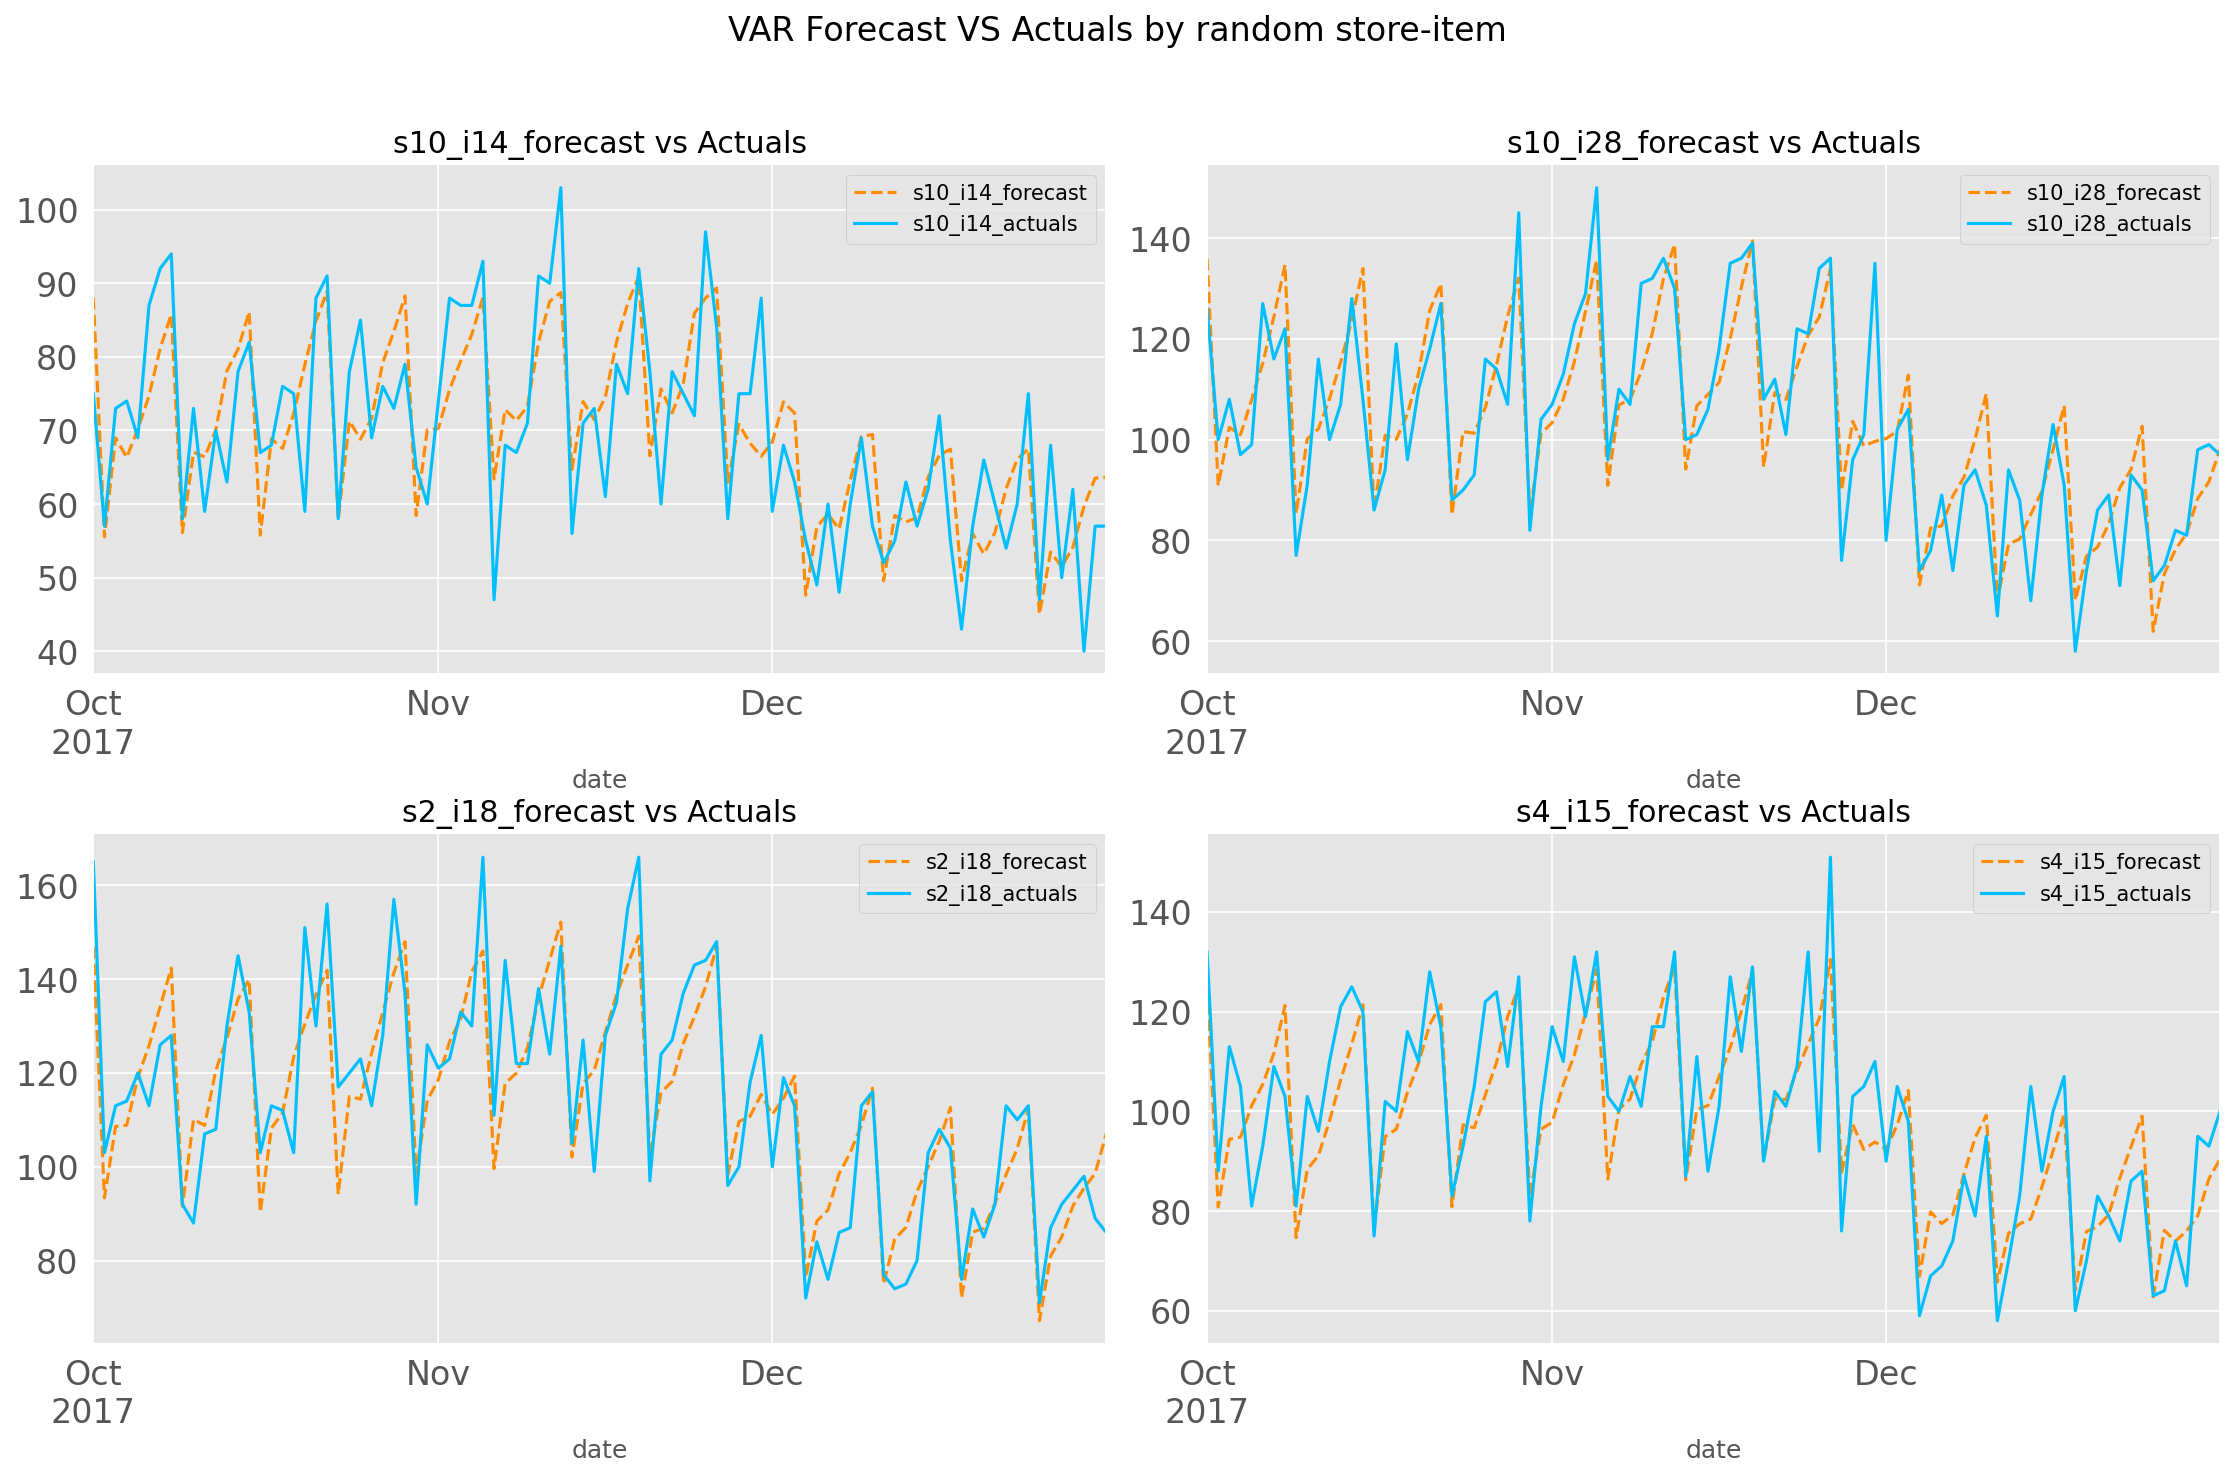

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(15,10))
for i, ax in enumerate( axes.flatten()):
    col = random.randint(1,valid_original.shape[1])
    df_results[df_results.columns[col]].plot(legend=True, ax=ax,linestyle='--',color='darkorange').autoscale(axis='x',tight=True)
    valid_original[valid_original.columns[col]].plot(legend=True, ax=ax, label=valid_original.columns[col]+'_actuals',color='deepskyblue');
    ax.set_title( f'{df_results.columns[col]} vs Actuals')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=16)

fig.suptitle("VAR Forecast VS Actuals by random store-item", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88);

In [24]:
#Calculating the Forecast Accuracy

#Calculating the mean squared error (average error of forecasts) and the lower Mean Square Error always reflects the better results 
def rmse_calculate(valid,forefast):
    columns = valid.columns.tolist()
    rmses=np.zeros(len(columns))
    means=np.zeros(len(columns))
    stds = np.zeros(len(columns))
    for i, col in enumerate( columns):
        mse = ((valid[col] - forefast[str(col)+'_forecast']) ** 2).mean()
        rmse = np.sqrt(mse)
        mean = valid[col].mean()
        std  = valid[col].std()
        rmses[i]=rmse
        means[i] = valid[col].mean()
        stds[i] = std
    df_rmses = pd.DataFrame({'observed_mean':means, 'rmses':rmses,'one_std':stds
                            },index =columns)
                        
    return df_rmses

In [25]:
df_rmses = rmse_calculate(valid_original,df_results)

In [26]:
df_rmses["store_item"]=df_rmses.index.tolist()
df_rmses

,observed_mean,rmses,one_std,store_item
s1_i1,20.228261,4.786380,5.855594,s1_i1
s1_i2,56.358696,7.776052,11.081696,s1_i2
s1_i3,34.010870,6.072510,8.044512,s1_i3
s1_i4,20.413043,4.551083,5.600534,s1_i4
s1_i5,17.130435,4.194145,5.386629,s1_i5
...,...,...,...,...
s10_i46,68.163043,9.711136,16.286769,s10_i46
s10_i47,25.663043,5.583483,6.789256,s10_i47
s10_i48,60.760870,8.224922,13.678707,s10_i48
s10_i49,33.086957,6.457852,9.121466,s10_i49


In [27]:
df_plot =df_rmses[:10]

In [28]:
df_plot

,observed_mean,rmses,one_std,store_item
s1_i1,20.228261,4.786380,5.855594,s1_i1
s1_i2,56.358696,7.776052,11.081696,s1_i2
s1_i3,34.010870,6.072510,8.044512,s1_i3
s1_i4,20.413043,4.551083,5.600534,s1_i4
s1_i5,17.130435,4.194145,5.386629,s1_i5
s1_i6,56.282609,8.242218,12.048734,s1_i6
s1_i7,55.076087,7.713632,12.443484,s1_i7
s1_i8,72.913043,9.519018,15.919890,s1_i8
s1_i9,47.032609,7.701568,11.068668,s1_i9
s1_i10,70.130435,9.916310,15.703445,s1_i10


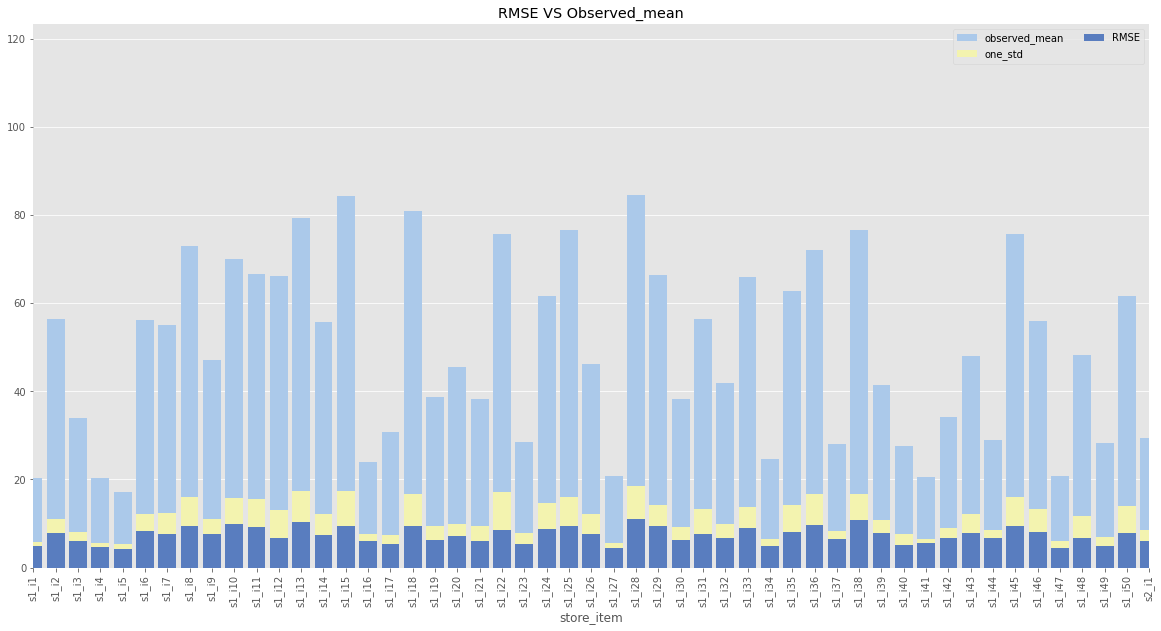

In [29]:
f, ax = plt.subplots(figsize=(20, 10))
sns.set_color_codes("pastel")

sns.barplot(y="observed_mean", x="store_item", data=df_rmses,
            label="observed_mean", color="b")
sns.barplot(y="one_std",x="store_item",data=df_rmses,
            label="one_std", color="y")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(y="rmses",x="store_item",data=df_rmses,
            label="RMSE", color="b")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(xlim=(0, 50), ylabel="",
       xlabel="store_item")
ax.set_title('RMSE VS Observed_mean')
ax.set_xticklabels(labels = df_rmses.index,rotation=90)
sns.despine(left=True, bottom=True)
plt.savefig('images/VAR_observed_mean_VS_rmse.png')

In [30]:
row_random_lst =random.choices(np.arange(df_rmses.shape[0]), k=16)
print("row_random_lst: ",row_random_lst)
store_item_random = df_rmses.iloc[row_random_lst]
store_item_random

row_random_lst:  [418, 478, 307, 353, 219, 428, 437, 232, 311, 131, 395, 492, 44, 360, 463, 132]


,observed_mean,rmses,one_std,store_item
s9_i19,44.706522,7.121664,10.015963,s9_i19
s10_i29,80.663043,10.117849,17.366304,s10_i29
s7_i8,55.739130,7.874202,12.450226,s7_i8
s8_i4,27.358696,5.253199,7.490040,s8_i4
s5_i20,37.913043,7.085779,9.691564,s5_i20
s9_i29,78.206522,11.056303,17.721619,s9_i29
s9_i38,89.521739,11.592738,21.422735,s9_i38
s5_i33,53.673913,7.088631,12.622245,s5_i33
s7_i12,51.021739,6.664538,11.195543,s7_i12
s3_i32,53.250000,8.433189,12.091796,s3_i32


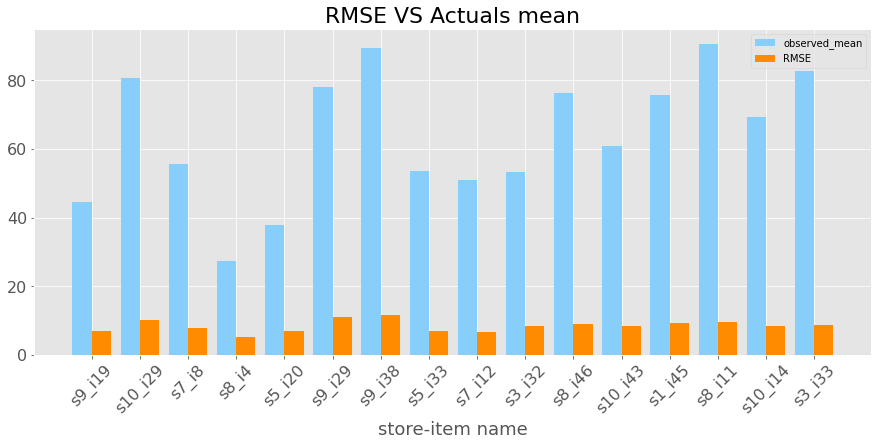

In [36]:
# Numbers of pairs of bars you want
N = store_item_random.shape[0]

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(15,6))

# Width of a bar 
width = 0.4       

# Plotting
plt.bar(ind, store_item_random.observed_mean , width, label='observed_mean',color='lightskyblue')
plt.bar(ind + width, store_item_random.rmses, width, label='RMSE',color='darkorange')


plt.xlabel('store-item name',fontsize=18)
plt.title('RMSE VS Actuals mean',fontsize=22)

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, store_item_random.store_item,rotation=45)
plt.tick_params(axis='both', which='major', labelsize=16)
# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.savefig('images/RMSE_VS_Actuals_mean.png')
plt.show()
         

In [57]:
df_results

,s1_i1_forecast,s1_i2_forecast,s1_i3_forecast,s1_i4_forecast,s1_i5_forecast,s1_i6_forecast,s1_i7_forecast,s1_i8_forecast,s1_i9_forecast,s1_i10_forecast,...,s10_i41_forecast,s10_i42_forecast,s10_i43_forecast,s10_i44_forecast,s10_i45_forecast,s10_i46_forecast,s10_i47_forecast,s10_i48_forecast,s10_i49_forecast,s10_i50_forecast
date,,,,,,,,,,,,,,,,,,,,,
2017-10-01,28.298917,72.856679,47.356985,26.003380,21.890530,69.661241,70.097584,95.244278,61.405969,86.896117,...,33.605511,56.638627,79.811497,44.687025,119.634494,87.320880,32.969850,77.940018,44.015547,101.464610
2017-10-02,17.481383,45.855226,30.171751,17.072458,13.424441,43.033878,45.911496,64.753175,40.688689,54.663601,...,21.207235,37.538912,53.414714,29.807675,78.776872,57.696325,21.908315,48.795373,28.183566,65.862604
2017-10-03,21.455338,54.251338,34.864771,19.349130,15.491632,52.729187,53.838048,73.982740,46.216864,66.657594,...,25.497885,41.743334,61.353904,33.616799,91.290299,68.033972,25.870813,55.520095,33.129094,75.940249
2017-10-04,22.685883,56.044288,35.393204,19.763823,17.342394,54.922954,52.343265,70.989415,49.110263,67.163207,...,26.206554,41.826024,61.956102,32.216808,90.518939,68.931929,25.187492,58.414700,35.499668,76.965618
2017-10-05,22.080135,57.429610,36.546841,20.746653,18.655997,56.252928,56.995386,75.131329,53.021786,71.616624,...,28.607151,44.186628,62.345679,32.331451,97.321693,70.706204,27.513665,62.114604,36.263142,81.582802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,15.517599,43.387061,26.111563,15.260324,13.870246,44.218889,42.282628,57.373110,36.543536,51.729792,...,20.550360,32.645848,48.916504,25.874763,74.720639,51.683870,19.483391,47.281117,29.627659,57.181583
2017-12-28,15.812252,45.445359,26.719738,16.417343,14.605893,45.529384,43.394682,58.270563,38.421272,56.569038,...,21.110229,33.672411,49.197471,26.916837,75.288905,56.212265,21.873703,49.176839,28.362280,62.236911
2017-12-29,18.029574,47.407600,28.630043,16.686400,14.438867,48.489659,45.767331,59.844593,39.393197,58.391675,...,20.654894,35.767938,51.198290,28.674319,78.922090,60.426277,22.629520,50.468322,30.504829,64.835108


In [58]:
df_results.to_csv('data/VAR_by_item.csv',index =True)

In [59]:
df_submmit = pd.concat(df_results.iloc[:,i] for i in range(df_results.shape[1]))

In [60]:
df_submmit =pd.DataFrame(df_submmit,columns=['VAR_forecast'])

In [61]:
df_submmit.head()

,VAR_forecast
date,
2017-10-01,28.298917
2017-10-02,17.481383
2017-10-03,21.455338
2017-10-04,22.685883
2017-10-05,22.080135


In [369]:
df_submmit.shape

(46000, 1)

In [62]:
df_submmit.to_csv('data/VAR_forecast.csv',index =True)

In [63]:
df_submmit[92:184]

,VAR_forecast
date,
2017-10-01,72.856679
2017-10-02,45.855226
2017-10-03,54.251338
2017-10-04,56.044288
2017-10-05,57.429610
...,...
2017-12-27,43.387061
2017-12-28,45.445359
2017-12-29,47.407600


In [375]:
np.ceil(9/2)

5.0